In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io
import numpy as np
import h5py
import sys
import gc

sys.path.append('../Visualization/')
from Data_Extractor import *
from Visualization import *

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path_train_set = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/posneg_seg_coord_split_thr1_128_16_train"

# Load training set
train_set = h5py.File(path_train_set, 'r')
train_pos_topleft_coord = np.array(train_set['positive_example'])
train_neg_topleft_coord = np.array(train_set['negative_example'])
train_raw_image = np.array(train_set['raw_image'])
train_road_mask = np.array(train_set['road_mask'])
train_set.close()
gc.collect()


43

In [34]:
path_cv_set = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/posneg_seg_coord_split_thr1_128_16_cv"

# Load cross-validation set
CV_set = h5py.File(path_cv_set, 'r')
CV_pos_topleft_coord = np.array(CV_set['positive_example'])
CV_neg_topleft_coord = np.array(CV_set['negative_example'])
CV_raw_image = np.array(CV_set['raw_image'])
CV_road_mask = np.array(CV_set['road_mask'])
CV_set.close()

gc.collect()

8913

In [ ]:
X, Y = CV_Data.get_patches(2)
print(X.shape, Y.shape)

In [49]:
class FCN_Data_Extractor (Data_Extractor):

    def __init__(self, raw_image, road_mask, img_size, pos_topleft_coord, neg_topleft_coord, normalization='mean', encoding='one-hot'):

        super(FCN_Data_Extractor, self).__init__(raw_image, road_mask, img_size, pos_topleft_coord, neg_topleft_coord, normalization, encoding)

    def _cal_norm_param(self):
        img_size = self.img_size
        mu = np.zeros((self.band, img_size, img_size))
        pixel_cnt = np.zeros((self.band, img_size, img_size))

        pos_cnt = 0
        neg_cnt = 0

        # Careful! norm params & weight not yet calculated
        for patch, rd_map, _ in self.iterate_data(norm=False, weighted=False):
            patch = patch[0]
            valid_img_mask = np.where(patch != -9999)
            valid_rd_mask = np.where(patch[0] != -9999)

            pixel_cnt[valid_img_mask] = pixel_cnt[valid_img_mask] + 1
            mu[valid_img_mask] = mu[valid_img_mask] + patch[valid_img_mask]

            if self.encoding == 'one-hot':
                pos_cnt += rd_map[0,:,:,1][valid_rd_mask].sum()
                neg_cnt += rd_map[0,:,:,0][valid_rd_mask].sum()
            else:
                pos_cnt += rd_map[valid_rd_mask].sum()
                neg_cnt += -(rd_map[valid_rd_mask]-1).sum()
    
        mu = mu.sum(axis=(1,2)) / pixel_cnt.sum(axis=(1,2))
        self.mu = mu
        self.neg_weight = pos_cnt / (pos_cnt+neg_cnt)
        self.pos_weight = neg_cnt / (pos_cnt+neg_cnt)

        assert (pos_cnt+neg_cnt) == pixel_cnt[0].sum()

        print("mu = ", mu)
        print("class weight [neg= %f, pos= %f]"%(self.neg_weight, self.pos_weight))

        if self.normalization == 'Gaussian':
            std = np.zeros((self.band, img_size, img_size))
            mu_ext = np.repeat(mu, [np.prod(patch[0].shape)]*patch.shape[0]).reshape(patch.shape)

            for patch in self.iterate_raw_image_patches(norm = False):
                patch = patch[0]
                valid_mask = np.where(patch != -9999)
                
                std[valid_mask] = std[valid_mask] + ((patch-mu_ext)**2)[valid_mask]
            
            std = np.sqrt(std.sum(axis=(1,2)) / pixel_cnt.sum(axis=(1,2)))
            self.std = std
            print('std = ', std)


    def _get_raw_patch(self, coord, norm):
        patch  = self.raw_image[:, coord[0]:coord[0]+self.img_size, coord[1]:coord[1]+self.img_size].copy()
        invalid_mask = np.where(patch == -9999)

        if norm:
            if self.normalization == 'mean':
                for channel_num in range(self.band):
                    patch[channel_num] = patch[channel_num] - self.mu[channel_num]
            elif self.normalization == 'Gaussian':
                for channel_num in range(self.band):
                    patch[channel_num] = (patch[channel_num] - self.mu[channel_num]) / self.std[channel_num]
        patch[invalid_mask] = 0
        return patch


    def _get_patch_label(self, coord):
        label = self.road_mask[coord[0]:coord[0]+self.img_size, coord[1]:coord[1]+self.img_size].copy()
        if self.encoding == 'one-hot':
            one_hot_label = np.zeros((self.img_size, self.img_size, 2))
            one_hot_label[:, :, 0][np.where(label == 0)] = 1
            one_hot_label[:, :, 1][np.where(label == 1)] = 1
            return one_hot_label
        return label

    def get_patches(self, batch_size, positive_num = 0, norm = True, wrap_around=True, weighted=True):
        X = []
        Y = []

        if positive_num > 0 and positive_num <= batch_size:
            # pos patches
            X_pos, Y_pos, self.pos_index = self._get_patches_from_topleft_coord (self.pos_topleft_coord,
                                                                     num_of_patches = positive_num,
                                                                     start_index = self.pos_index,
                                                                     norm = norm, 
                                                                     wrap_around=wrap_around)
            
            negative_num = batch_size - positive_num
            X_neg, Y_neg, self.neg_index = self._get_patches_from_topleft_coord (self.neg_topleft_coord,
                                                                     num_of_patches = negative_num,
                                                                     start_index = self.neg_index,
                                                                     norm = norm, 
                                                                     wrap_around=wrap_around)
            
            X.extend (X_pos)
            Y.extend (Y_pos)
            
            X.extend (X_neg)
            Y.extend (Y_neg)
        
        else: # sample batches randomly
            X, Y, self.index = self._get_patches_from_topleft_coord (self.topleft_coordinate,
                                                                      num_of_patches = batch_size,
                                                                      start_index = self.index,
                                                                      norm = norm,
                                                                      wrap_around=wrap_around)

        X = np.array(X)
        Y = np.array(Y)
        W = Y.copy()
    
        if weighted:
            W[:,:,:,0] *= self.neg_weight
            W[:,:,:,1] *= self.pos_weight
            
        for idx in len(X):
            invalid_mask = np.where(X[idx][0] == -9999)
            print(W[idx][invalid_mask])
            W[idx][invalid_mask][:] = 0
            
        return X, Y, W.sum(axis=-1)


    def iterate_data (self, norm=True, weighted=True):
        for coord in self.topleft_coordinate:
            x = np.array([self._get_raw_patch(coord, norm)])
            y = np.array([self._get_patch_label(coord)])
            weight = y.copy()

            if weighted:
                weight[:,:,:,0] *= self.neg_weight
                weight[:,:,:,1] *= self.pos_weight

            yield x, y, weight.sum(axis=-1)


    def iterate_data_with_coord (self, norm=True, weighted=True):
        for coord in self.topleft_coordinate:
            x = np.array([self._get_raw_patch(coord, norm)])
            y = np.array([self._get_patch_label(coord)])
            weight = y.copy()

            if weighted and self.encoding == 'one-hot':
                weight[:,:,:,0] *= self.neg_weight
                weight[:,:,:,1] *= self.pos_weight
            
            yield coord, x, y, weight.sum(axis=-1)

In [6]:
a = np.arange(100).reshape(2,50)
print(a.shape, len(a))

(2, 50) 2


In [3]:
CV_FCN_Data = FCN_Data_Extractor (CV_raw_image, CV_road_mask, 128,
                                  pos_topleft_coord = CV_pos_topleft_coord,
                                  neg_topleft_coord = CV_neg_topleft_coord,
                                  normalization='Gaussian')

mu =  [ 145.02183288  190.77598344  361.33590698  366.91707464 2380.64990791
 1375.52599508  734.46670819]
class weight [neg= 0.025683, pos= 0.974317]
std =  [120.35045017 142.82855956 224.8264348  259.40579968 811.03520645
 842.84666761 560.72898821]


362

In [3]:
Train_FCN_Data = FCN_Data_Extractor (train_raw_image, train_road_mask, 128,
                                  pos_topleft_coord = train_pos_topleft_coord,
                                  neg_topleft_coord = train_neg_topleft_coord,
                                  normalization='Gaussian')
len(Train_FCN_Data.topleft_coordinate)

mu =  [ 140.42133132  186.22724995  365.92096392  358.74944958 2449.2505917
 1352.83568307  708.04858695]
class weight [neg= 0.014629, pos= 0.985371]
std =  [113.04792058 135.17366614 230.99671408 248.71498611 952.23666562
 825.62200511 523.41884702]


38847

In [73]:
class Pred_Data_Extractor ():

    def __init__(self, raw_image, step, size, mu=None, std=None, normalization='mean', is_valid=lambda patch: (patch != -9999).all()):
        self.raw_image = raw_image
        self.band = raw_image.shape[0]
        self.step = step
        self.size = size

        self.is_valid = is_valid

        self.mu = mu
        self.std  = std
        self.normalization = normalization

        assert self.band == 7
        assert self.normalization in set(['mean', 'Gaussian'])


    def norm_fn (self, patch):
        if self.normalization == 'mean':
            for channel_num in range(self.band):
                patch[channel_num] = patch[channel_num] - self.mu[channel_num]
        else:
            for channel_num in range(self.band):
                patch[channel_num] = (patch[channel_num] - self.mu[channel_num]) / self.std[channel_num]
        return patch

    def iterate_raw_image_patches (self, norm=True):
        raw_image = self.raw_image
        size = self.size
        step = self.step

        row_idx = 0
        while(row_idx+size <= raw_image.shape[1]):
            col_idx = 0
            while(col_idx+size <= raw_image.shape[2]):
                patch = raw_image[:, row_idx:row_idx+size, col_idx:col_idx+size].copy()
                if self.is_valid(patch):
                    if norm:
                        patch = self.norm_fn(patch)

                    yield np.array([patch])

                col_idx += step
            row_idx += step

    def iterate_raw_image_patches_with_coord (self, norm=True):
        raw_image = self.raw_image
        size = self.size
        step = self.step

        row_idx = 0
        while(row_idx+size <= raw_image.shape[1]):
            col_idx = 0
            while(col_idx+size <= raw_image.shape[2]):
                patch = raw_image[:, row_idx:row_idx+size, col_idx:col_idx+size].copy()                
                if self.is_valid(patch):
                    if norm:
                        patch = self.norm_fn(patch)
                    yield (row_idx, col_idx), np.array([patch])

                col_idx += step
            row_idx += step

In [ ]:
CV_pred = Pred_Data_Extractor(CV_raw_image, step=16, size=128, 
                              mu=CV_FCN_Data.mu, std=CV_FCN_Data.std, normalization='Gaussian',
                              is_valid=lambda patch: (patch == -9999).sum() / np.prod(patch.shape) < 1/100)

In [5]:
Train_pred = Pred_Data_Extractor(train_raw_image, step=16, size=128, 
                              mu=Train_FCN_Data.mu, std=Train_FCN_Data.std, normalization='Gaussian',
                              is_valid=lambda patch: (patch == -9999).sum() / np.prod(patch.shape) < 1/100)

In [7]:
coord_list = []
for coord, patch in Train_pred.iterate_raw_image_patches_with_coord():
    coord_list.append(coord)
coord_list = np.array(coord_list)

In [85]:
set([(k[0],k[1]) for k in coord_list]) == set([(k[0],k[1]) for k in CV_FCN_Data.topleft_coordinate])

True

In [8]:
set([(k[0],k[1]) for k in coord_list]) == set([(k[0],k[1]) for k in Train_FCN_Data.topleft_coordinate])

True

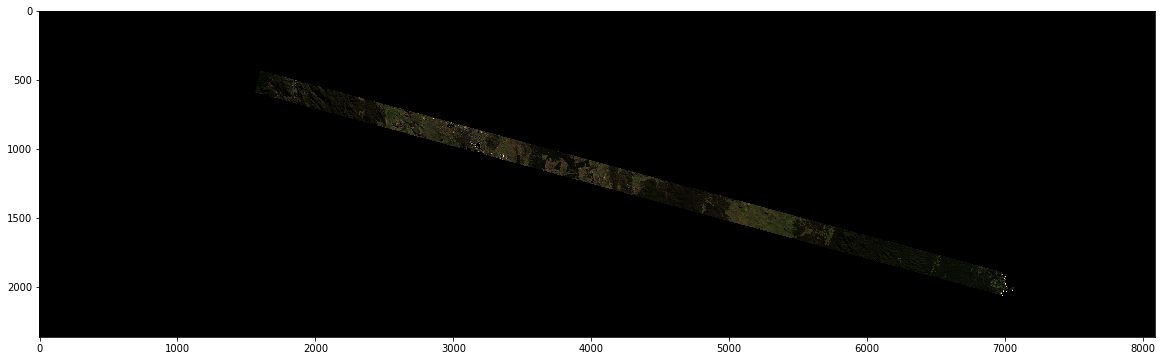

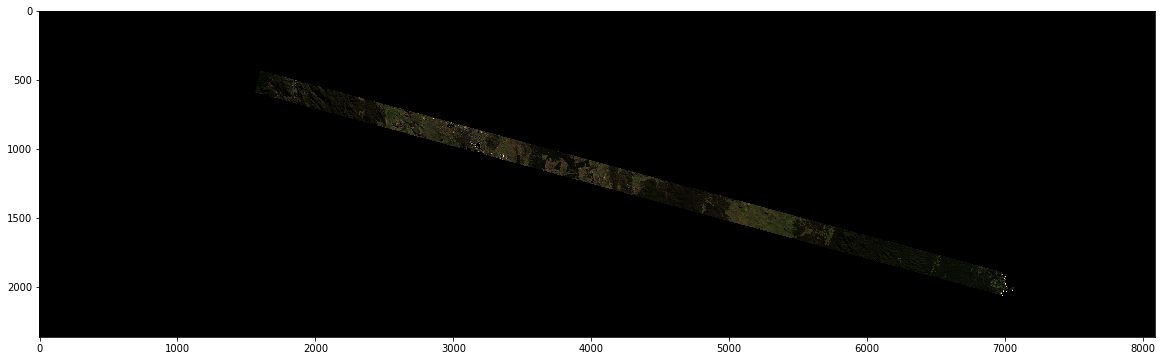

In [59]:
show_raw_image(CV_raw_image, size=-1)
show_raw_image(CV_pred.raw_image, size=-1)

In [14]:
import h5py
import gc

path_train_set = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/posneg_seg_coord_split_thr1_128_16_train"
path_cv_set = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/posneg_seg_coord_split_thr1_128_16_cv"

# Load training set
train_set = h5py.File(path_train_set, 'r')
train_pos_topleft_coord = np.array(train_set['positive_example'])
train_neg_topleft_coord = np.array(train_set['negative_example'])
train_raw_image = np.array(train_set['raw_image'])
train_road_mask = np.array(train_set['road_mask'])
train_set.close()

# Load cross-validation set
CV_set = h5py.File(path_cv_set, 'r')
CV_pos_topleft_coord = np.array(CV_set['positive_example'])
CV_neg_topleft_coord = np.array(CV_set['negative_example'])
CV_raw_image = np.array(CV_set['raw_image'])
CV_road_mask = np.array(CV_set['road_mask'])
CV_set.close()

gc.collect()

1407

In [4]:
x, y, w = CV_FCN_Data.get_patches(2)
print(x.shape, y.shape, w.shape)

(2, 7, 128, 128) (2, 128, 128, 2) (2, 128, 128)


In [10]:
coord_list

array([], dtype=float64)

In [ ]:
y_f = y.reshape(-1,2)
w_f = w.reshape(-1)
for i in range(y_f.shape[0]):
    print(y_f[i], w_f[i])
    assert sum(np.array([CV_FCN_Data.neg_weight, CV_FCN_Data.pos_weight]) * y_f[i]) == w_f[i] 